### Final Project Code

In [14]:
pip install transformers torchvision pillow

### BLIP 모델 준비 및 이미지 캡셔닝 모델 준비, attention map

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Attention Map Shape: (1, 577, 577)


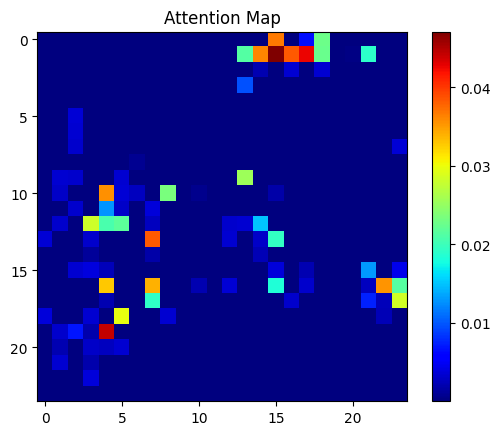

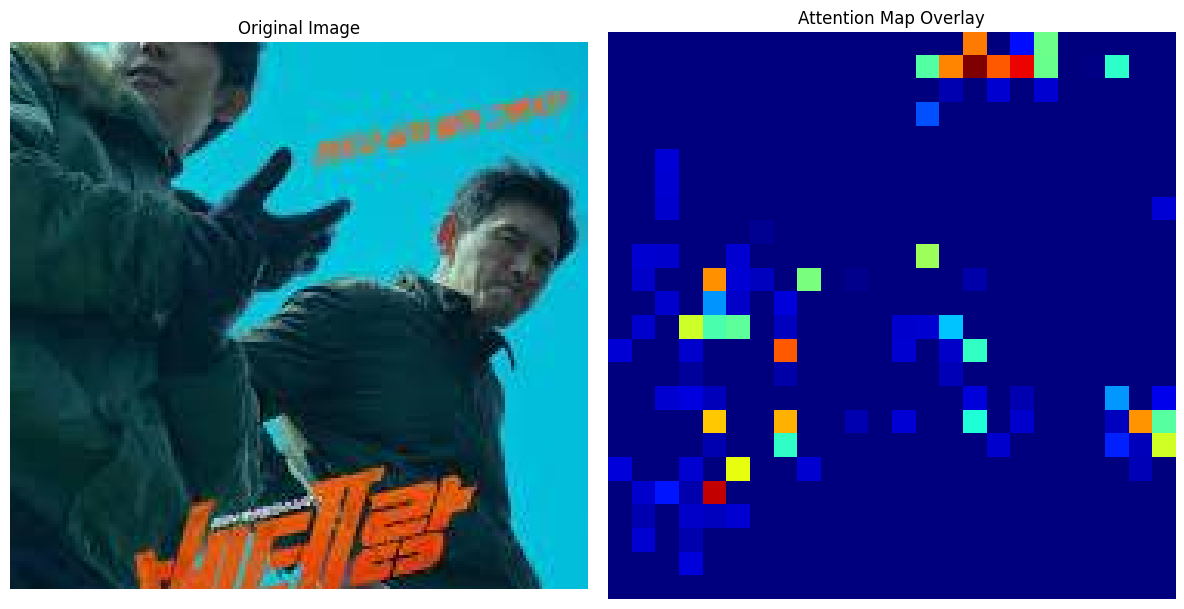

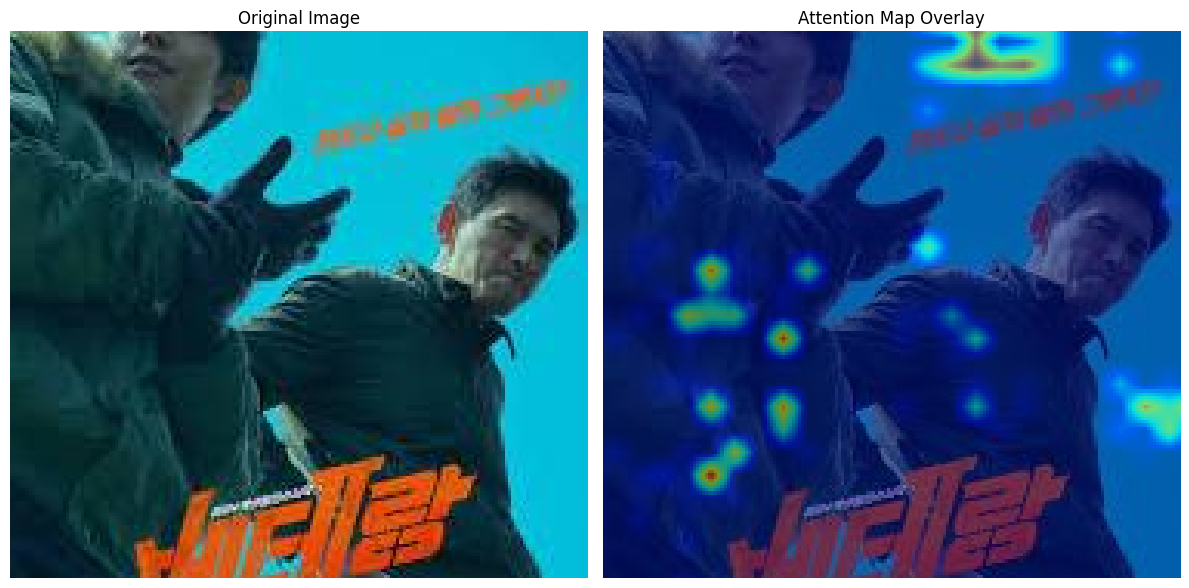

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering
from google.colab import drive
import pandas as pd
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
from transformers import AutoProcessor, AutoModelForVisualQuestionAnswering

### 이미지 캡셔닝 모델, 프로세서 불러오기
processor_cap = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_cap = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
drive.mount('/content/drive')

# 모델과 프로세서 불러오기
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# 이미지와 질문 설정
image_path = "/content/drive/MyDrive/베테랑2.jpeg"
# image_path = "/content/drive/My Drive/toystory.png"  # 이미지 경로
image = Image.open(image_path)
question = "What movie is this?"

# 입력 데이터 준비
inputs = processor(images=image, text=question, return_tensors="pt")

# Attention 추출을 위한 Hook 설정
attention_map = None


# Attention 추출을 위한 Hook
def save_attention_hook(module, input, output):
    global attention_map
    # QKV 분리 (output은 [batch_size, num_patches, 3 * hidden_size] 형태)
    batch_size, num_patches, _ = output.size()
    hidden_size = output.size(-1) // 3

    # Q, K, V 분리
    q, k, v = output.view(batch_size, num_patches, 3, hidden_size).unbind(dim=2)

    # Attention Map 계산: Q * K^T / sqrt(d_k)
    d_k = q.size(-1)
    attention_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    # Softmax를 통해 Attention Map 생성
    attention_map = torch.softmax(attention_scores, dim=-1)


# Hook 등록 (마지막 Encoder Layer의 self_attn.qkv에서 실행)
hook_handle = model.vision_model.encoder.layers[-1].self_attn.qkv.register_forward_hook(save_attention_hook)

# 모델 실행
with torch.no_grad():
    outputs = model.generate(**inputs)

# Hook 제거
hook_handle.remove()


# Attention Map 확인
if attention_map is not None:
    attention_map = attention_map.detach().cpu().numpy()
    print("Attention Map Shape:", attention_map.shape)  # (batch_size, num_patches, num_patches)
else:
    print("Attention Map was not captured.")

# import matplotlib.pyplot as plt
# import numpy as np

# # 특정 패치의 Attention Map (예: 첫 번째 패치 기준)
# patch_attention = attention_map[0, 0, :].reshape(14, 14)  # 14x14은 Vision Transformer 기본 설정

# # 이미지 시각화
# plt.imshow(image)
# plt.imshow(patch_attention, cmap='jet', alpha=0.5)  # Attention Map을 겹침
# plt.colorbar()
# plt.title("Attention Map Overlay")
# plt.show()
# print("Attention Map Shape:", attention_map.shape)
# # 예: (batch_size, num_patches, num_patches) => (1, 577, 577)
# Attention Map에서 CLS 토큰을 제외하고 2D 배열로 변환
num_patches = int((attention_map.shape[1] - 1) ** 0.5)  # CLS 토큰 제외
patch_attention = attention_map[0, 1:, 1:].mean(axis=0).reshape(num_patches, num_patches)  # CLS 제외, 평균 계산

# 시각화
import matplotlib.pyplot as plt
plt.imshow(patch_attention, cmap='jet')
plt.colorbar()
plt.title("Attention Map")
plt.show()

# 원본 이미지 크기에 맞게 패치 배열을 업샘플링
from skimage.transform import resize

resized_attention = resize(patch_attention, image.size[::-1])  # 원본 이미지 크기에 맞게 변환 (H, W)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 원본 이미지 표시
axes[0].imshow(image)
axes[0].axis("off")
axes[0].set_title("Original Image")

# Attention Map Overlay 표시
axes[1].imshow(image)
axes[1].imshow(patch_attention, cmap='jet')  # Attention Map을 겹침
axes[1].axis("off")
axes[1].set_title("Attention Map Overlay")

plt.tight_layout()
plt.show()

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 원본 이미지 표시
axes[0].imshow(image)
axes[0].axis("off")
axes[0].set_title("Original Image")

# Attention Map Overlay 표시
axes[1].imshow(image)
axes[1].imshow(resized_attention, cmap='jet', alpha=0.5)  # Attention Map을 겹침
axes[1].axis("off")
axes[1].set_title("Attention Map Overlay")

plt.tight_layout()
plt.show()


In [16]:
#모델의 구조 확인
print(model.vision_model)

BlipVisionModel(
  (embeddings): BlipVisionEmbeddings(
    (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (encoder): BlipEncoder(
    (layers): ModuleList(
      (0-11): 12 x BlipEncoderLayer(
        (self_attn): BlipAttention(
          (dropout): Dropout(p=0.0, inplace=False)
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (projection): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): BlipMLP(
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (post_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)


In [17]:
#encoder layer의 구조 확인
print(model.vision_model.encoder.layers[-1])


BlipEncoderLayer(
  (self_attn): BlipAttention(
    (dropout): Dropout(p=0.0, inplace=False)
    (qkv): Linear(in_features=768, out_features=2304, bias=True)
    (projection): Linear(in_features=768, out_features=768, bias=True)
  )
  (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): BlipMLP(
    (activation_fn): GELUActivation()
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
  )
  (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)


### 데이터셋 준비 (MovieLens 1M) 및 살펴보기

In [18]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

movies = pd.read_csv(
    '/content/drive/My Drive/ml-1m/movies.dat',
    sep='::',
    engine='python',
    header=None,
    names=['movie_id', 'title', 'genres'],
    encoding='latin-1'
)
# 2. 텍스트 데이터 생성 (제목 + 장르)
movies['text'] = movies['title'] + " | " + movies['genres']

# 확인
print(movies.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   movie_id                               title                        genres  \
0         1                    Toy Story (1995)   Animation|Children's|Comedy   
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy   
2         3             Grumpier Old Men (1995)                Comedy|Romance   
3         4            Waiting to Exhale (1995)                  Comedy|Drama   
4         5  Father of the Bride Part II (1995)                        Comedy   

                                             text  
0  Toy Story (1995) | Animation|Children's|Comedy  
1   Jumanji (1995) | Adventure|Children's|Fantasy  
2        Grumpier Old Men (1995) | Comedy|Romance  
3         Waiting to Exhale (1995) | Comedy|Drama  
4     Father of the Bride Part II (1995) | Comedy  


### 영화 포스터 input

In [19]:
# 영화 포스터 이미지 열기
# image_path = "/content/drive/My Drive/toystory.png"
# image_path = "/content/drive/MyDrive/intotheworld.webp"
# image_path = "/content/drive/MyDrive/Sabrina.jpg"
image_path = "/content/drive/MyDrive/베테랑2.jpeg"
# image_path = "/content/drive/MyDrive/30일.webp"
# image_path = "/content/drive/MyDrive/파일럿.jpeg"
image = Image.open(image_path)

In [20]:
# 질문 생성
question = "What movie is this?"  # 영화 제목을 묻는 질문
# 또는
# question = "What genre is this movie?"  # 영화 장르를 묻는 질문

In [21]:
# 입력 처리
inputs = processor(images=image, text=question, return_tensors="pt")

# 답변 생성
out = model.generate(**inputs)
answer = processor.decode(out[0], skip_special_tokens=True)

print(f"Answer: {answer}")

### 이미지 캡셔닝 처리
inputs = processor_cap(images=image, return_tensors="pt")
outputs = model_cap.generate(**inputs)
caption = processor_cap.decode(outputs[0], skip_special_tokens=True)
print("Caption:", caption)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Answer: van heusen
Caption: the movie poster for the movie ' s upcoming release


### 다양한 프롬프트로 영화 묘사 테스트 및 영화 추천

In [ ]:
from difflib import get_close_matches
# 영화 장르를 묻는 질문
#(사용)- 구체적인 질문(예시를 구체적으로 제공) -> 비교적 정확한 답변 나옴 (코사인 유사도 65%)
question = f"Given the movie '{caption}', its main themes and plot, can you classify it into one of these genres? Action, Drama, Comedy, Sci-Fi, Fantasy, Horror, Animation, Thriller, or Romance?"

# question = f"This movie is '{answer}', given {caption} its main themes and plot, can you classify it into one of these genres? Action, Drama, Comedy, Sci-Fi, Fantasy, Horror, Animation, Thriller, or Romance?"


#- 추상적인 질문 -> 전혀 다른 결과가 나옴 (코사인 유사도 0%)
# question = f"Given that '{caption}', what genre would it best fit?"

# question = f"Given the movie title '{caption}', can you tell me its primary genre?"

#(사용) 성능이 떨어짐.. -> 첫번째 코사인 유사도는 77% 두번째 코사인 유사도는 0
# question = f"Considering the main themes, tone, and style of the movie '{caption}', can you categorize it into one of these genres: Action, Drama, Comedy, Sci-Fi, Fantasy, Horror, Animation, Thriller, or Romance?"

#sci fi로 예측
# question = f"Based on the movie '{caption}', what genre does it belong to? The genre should be one of the following: Action, Drama, Comedy, Sci-Fi, Fantasy, Horror, Animation, Thriller, or Romance."

#호러로 예측함
# question = f"Given the emotional tone and central themes of the movie '{caption}', which genre fits best? Please choose from Action, Drama, Comedy, Sci-Fi, Fantasy, Horror, Animation, Thriller, or Romance."


# 답변 생성
inputs = processor(images=image, text=question, return_tensors="pt")
out = model.generate(**inputs)
answer = processor.decode(out[0], skip_special_tokens=True)

print(f"Genre: {answer}")

available_genres = {
    'Horror', 'Documentary', 'Musical', 'Thriller', 'Drama', 'Crime', 'Action',
    'Sci-Fi', 'Mystery', 'Romance', 'War', 'Western', 'Comedy', 'Animation',
    'Film-Noir', "Children's", 'Adventure', 'Fantasy'
}



# 1. 입력된 장르를 genres와 유사하게 매핑하는 함수 추가
def match_genre(predicted_genre, available_genres):
    # 간단히 단어가 포함되는지 확인
    for genre in available_genres:
        if predicted_genre.lower() in genre.lower():
            return genre

    return None

# 2. 장르 후보 리스트 생성
available_genres = set("|".join(movies['genres']).split("|"))

# 3. 모델이 반환한 장르를 매칭
# answer = "romance"
def find_closest_genre(predicted_genre, available_genres):
    closest_matches = get_close_matches(predicted_genre, available_genres, n=1, cutoff=0.1)
    return closest_matches[0] if closest_matches else None

matched_genre = find_closest_genre(answer, available_genres)

# matched_genre = match_genre(answer, available_genres)

# 4. 매칭된 장르로 영화 추천
if matched_genre:
    recommended_movies = movies[movies['genres'].str.contains(matched_genre, case=False)]
    print(f"Matched Genre: {matched_genre}")
    print(f"Recommended Movies: {recommended_movies.head()}")
else:
    print("No matching genre found.")

# 해당 장르에 맞는 영화 추천
# recommended_movies = movies[movies['genres'].str.contains(answer, case=False)]
# print("결과\n")
# print(f"Recommended Movies: {recommended_movies.head()}")


Genre: action movie
Matched Genre: Action
Recommended Movies:     movie_id                    title                     genres  \
5          6              Heat (1995)      Action|Crime|Thriller   
8          9      Sudden Death (1995)                     Action   
9         10         GoldenEye (1995)  Action|Adventure|Thriller   
14        15  Cutthroat Island (1995)   Action|Adventure|Romance   
19        20       Money Train (1995)                     Action   

                                                 text  
5                 Heat (1995) | Action|Crime|Thriller  
8                        Sudden Death (1995) | Action  
9        GoldenEye (1995) | Action|Adventure|Thriller  
14  Cutthroat Island (1995) | Action|Adventure|Rom...  
19                        Money Train (1995) | Action  


### 프롬프트 질문으로 얻은 answer와 데이터셋 내의 가장 잘 매칭되는 장르 선정

In [23]:
# 코사인 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

available_genres = {
    'Horror', 'Documentary', 'Musical', 'Thriller', 'Drama', 'Crime', 'Action',
    'Sci-Fi', 'Mystery', 'Romance', 'War', 'Western', 'Comedy', 'Animation',
    'Film-Noir', "Children's", 'Adventure', 'Fantasy'
}

predicted_genre = answer
print(answer)
# 영화 장르 리스트로 벡터화 준비
genre_list = list(available_genres)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(genre_list + [predicted_genre])

# 유사도 계산
similarity_scores = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])

# 유사도 출력
print(f"Similarity Scores: {similarity_scores.flatten()}")
print(answer)

action movie
Similarity Scores: [0.         0.         0.         0.65945268 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
action movie


### 최종 유사도 

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

### 매칭된 장르와 인풋 영화와의 연관성 코사인 유사도

# matched_genre와 answer 두 텍스트 간의 유사도 계산
texts_to_compare = [matched_genre, answer]

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(texts_to_compare)

# 코사인 유사도 계산
similarity_score = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])

# 결과 출력
print(f"Similarity between matched_genre and answer: {similarity_score[0][0]}")


Similarity between matched_genre and answer: 0.5797386715376658


### BLIP 이외의 모델로 테스트 (위의 코드와 같은 구조)

In [ ]:
#######################################

from transformers import ViltProcessor, ViltForQuestionAnswering
from PIL import Image
import torch
from google.colab import drive
import pandas as pd
from difflib import get_close_matches
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. ViLT Processor와 모델 불러오기
processor_vilt = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model_vilt = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# 2. 영화 데이터 로드
drive.mount('/content/drive')

movies = pd.read_csv(
    '/content/drive/My Drive/ml-1m/movies.dat',
    sep='::',
    engine='python',
    header=None,
    names=['movie_id', 'title', 'genres'],
    encoding='latin-1'
)
movies['text'] = movies['title'] + " | " + movies['genres']
print(movies.head())

# 3. 영화 포스터 이미지 열기
image_path = "/content/drive/MyDrive/베테랑2.jpeg"
image = Image.open(image_path)

# 4. 질문 생성 (영화 제목 묻기)
question = "What movie is this?"  # 영화 제목을 묻는 질문

# 5. 입력 처리 (ViLTProcessor 사용)
inputs = processor_vilt(images=image, text=question, return_tensors="pt")

# 6. 답변 생성 (generate 대신 forward 사용)
outputs = model_vilt(**inputs)
answer = outputs.logits.argmax(dim=-1)  # 가장 높은 확률을 가진 답변 선택

# 7. 답변을 처리하여 텍스트로 변환
answer = processor_vilt.decode(answer[0], skip_special_tokens=True)
print(f"Answer: {answer}")

# 8. 이미지 캡셔닝 처리 (ViLT는 이미지 캡셔닝을 직접적으로 지원하지 않지만, 다른 모델을 사용할 수 있음)
caption_question = "Can you describe this movie image?"
inputs_caption = processor_vilt(images=image, text=caption_question, return_tensors="pt")
caption_out = model_vilt(**inputs_caption)
caption = processor_vilt.decode(caption_out.logits.argmax(dim=-1)[0], skip_special_tokens=True)
print("Caption:", caption)

# 9. 장르 예측 질문 처리
# 모델이 처리할 수 있는 텍스트 길이로 축소하기
caption = caption[:50]  # 텍스트의 길이를 줄여서 모델에 입력

question = f"Given the movie '{answer}', its main themes and plot, can you classify it into one of these genres? Action, Drama, Comedy, Sci-Fi, Fantasy, Horror, Animation, Thriller, or Romance?"


# 답변 생성
inputs = processor(images=image, text=question, return_tensors="pt")
out = model.generate(**inputs)
answer = processor.decode(out[0], skip_special_tokens=True)

print(f"Genre: {answer}")

available_genres = {
    'Horror', 'Documentary', 'Musical', 'Thriller', 'Drama', 'Crime', 'Action',
    'Sci-Fi', 'Mystery', 'Romance', 'War', 'Western', 'Comedy', 'Animation',
    'Film-Noir', "Children's", 'Adventure', 'Fantasy'
}



# 1. 입력된 장르를 genres와 유사하게 매핑하는 함수 추가
def match_genre(predicted_genre, available_genres):
    # 간단히 단어가 포함되는지 확인
    for genre in available_genres:
        if predicted_genre.lower() in genre.lower():
            return genre

    return None

# 2. 장르 후보 리스트 생성
available_genres = set("|".join(movies['genres']).split("|"))

# 3. 모델이 반환한 장르를 매칭
# answer = "romance"
def find_closest_genre(predicted_genre, available_genres):
    closest_matches = get_close_matches(predicted_genre, available_genres, n=1, cutoff=0.1)
    return closest_matches[0] if closest_matches else None

matched_genre = find_closest_genre(answer, available_genres)

# matched_genre = match_genre(answer, available_genres)

# 4. 매칭된 장르로 영화 추천
if matched_genre:
    recommended_movies = movies[movies['genres'].str.contains(matched_genre, case=False)]
    print(f"Matched Genre: {matched_genre}")
    print(f"Recommended Movies: {recommended_movies.head()}")
else:
    print("No matching genre found.")

# 해당 장르에 맞는 영화 추천
# recommended_movies = movies[movies['genres'].str.contains(answer, case=False)]
# print("결과\n")
# print(f"Recommended Movies: {recommended_movies.head()}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   movie_id                               title                        genres  \
0         1                    Toy Story (1995)   Animation|Children's|Comedy   
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy   
2         3             Grumpier Old Men (1995)                Comedy|Romance   
3         4            Waiting to Exhale (1995)                  Comedy|Drama   
4         5  Father of the Bride Part II (1995)                        Comedy   

                                             text  
0  Toy Story (1995) | Animation|Children's|Comedy  
1   Jumanji (1995) | Adventure|Children's|Fantasy  
2        Grumpier Old Men (1995) | Comedy|Romance  
3         Waiting to Exhale (1995) | Comedy|Drama  
4     Father of the Bride Part II (1995) | Comedy  
Answer: interest
Caption: [unused2]


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Genre: sci fi movie
Matched Genre: Film-Noir
Recommended Movies:      movie_id                         title                            genres  \
162       164  Devil in a Blue Dress (1995)  Crime|Film-Noir|Mystery|Thriller   
317       320                 Suture (1993)                Film-Noir|Thriller   
537       541           Blade Runner (1982)                  Film-Noir|Sci-Fi   
698       707       Mulholland Falls (1996)          Crime|Film-Noir|Thriller   
736       746          Force of Evil (1948)                         Film-Noir   

                                                  text  
162  Devil in a Blue Dress (1995) | Crime|Film-Noir...  
317                 Suture (1993) | Film-Noir|Thriller  
537             Blade Runner (1982) | Film-Noir|Sci-Fi  
698  Mulholland Falls (1996) | Crime|Film-Noir|Thri...  
736                   Force of Evil (1948) | Film-Noir  


In [ ]:
# 코사인 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

available_genres = {
    'Horror', 'Documentary', 'Musical', 'Thriller', 'Drama', 'Crime', 'Action',
    'Sci-Fi', 'Mystery', 'Romance', 'War', 'Western', 'Comedy', 'Animation',
    'Film-Noir', "Children's", 'Adventure', 'Fantasy'
}

predicted_genre = answer

# 영화 장르 리스트로 벡터화 준비
genre_list = list(available_genres)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(genre_list + [predicted_genre])

# 유사도 계산
similarity_scores = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])

# 유사도 출력
print(f"Similarity Scores: {similarity_scores.flatten()}")
print(answer)

Similarity Scores: [0.         0.         0.         0.         0.         0.
 0.77855836 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
sci fi movie


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

### 매칭된 장르와 인풋 영화와의 연관성 코사인 유사도

# matched_genre와 answer 두 텍스트 간의 유사도 계산
texts_to_compare = [matched_genre, answer]

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(texts_to_compare)

# 코사인 유사도 계산
similarity_score = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])

# 결과 출력
print(f"Similarity between matched_genre and answer: {similarity_score[0][0]}")


Similarity between matched_genre and answer: 0.0
